# Script to create ImageFolder format for tooth sample data

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

also: augment data to get balanced classes

structure

torch_imagefolder/mpi/m,p,i

torch_imagefolder/upperlower/upper,lower

-> no predetermined train and test sets to not fit to particular train/test split


In [68]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [76]:
# borderValue: color to use in fill-in pixels after translation
def translate(image, tx, ty, borderValue = (255,255,255)):
    M = np.array([[1.,0.,tx],[0.,1.,ty]])
    height, width = image.shape[:2]
    translated_image = cv2.warpAffine(src=image, M=M, dsize=(width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=borderValue)
    return translated_image

In [3]:
# script parameters
data_versions = [3,4,5]
image_path = '/home/riikoro/fossil_data/tooth_samples'

In [31]:
# Conversion from upper/lower and azure_labels.txt to combined labels.csv file (u (binary, is upper jaw), tooth (azure output word))
# import os
# for v in [3,4]:
#     img_root = f'{image_path}/v{v}'
#     azure = pd.read_csv(f'{img_root}/azure_labels.txt',header=None,names=['tooth'])
#     upper = pd.read_csv(f'{img_root}/upper_lower_labels.txt')
#     combined = pd.DataFrame()
#     combined['tooth'] = azure['tooth']
#     combined['u'] = upper['upper (-1 = unknown)']
#     combined.to_csv(f'{img_root}/labels.txt', index=False)

1. Get all images with labels
2. Create directory torch_imagefolder, subfolders upperlower and MPI with subdirectories for all classes
2. MPI: check balances -> augment so that balances equal
3. Divide into M P and I
5. Save images to MPI folders
6. Upper and lower: check balances, augment if necessary
7. Divide into upper lower
8. Save images to upper lower folders

In [43]:
# 1. Get all labels
def clean_azure_labels(data_version):
    tooth_labels = pd.read_csv(f'{image_path}/v{data_version}/labels.txt')
    tooth_labels['tooth_type'] = tooth_labels['tooth'].str[0] # extract first character
    del tooth_labels['tooth']
    # set labels where tooth type is unexpected to none
    tooth_labels.loc[~tooth_labels['tooth_type'].isin(['m', 'p', 'i', 'M', 'P', 'I']), 'tooth_type'] = None
    # uppercase all tooth type letters
    tooth_labels['tooth_type'] = tooth_labels['tooth_type'].str.upper()
    # add column for image index & data version to allow combining datasets
    tooth_labels['image_i'] = tooth_labels.index
    tooth_labels['data_v'] = data_version
    return tooth_labels

label_dfs = []
for data_v in data_versions:
    label_dfs.append(clean_azure_labels(data_v))

tooth_labels = pd.concat(label_dfs, axis=0)
tooth_labels

,u,tooth_type,image_i,data_v
0,1,M,0,3
1,0,None,1,3
2,0,None,2,3
3,0,M,3,3
4,1,P,4,3
...,...,...,...,...
43,1,I,43,5
44,1,I,44,5
45,1,I,45,5
46,1,I,46,5


In [53]:
# 1. Get all images
filenames = []
for i, label in tooth_labels.iterrows():
    filename = f'{image_path}/v{label["data_v"]}/{label["image_i"]}.png'
    filenames.append(filename)

tooth_labels['image_path'] = filenames
tooth_labels.iloc[123]
tooth_labels.to_csv('kukkuu.csv', index=False)

In [59]:
# try creating new directory with torch_imagefolder_i name until a nonreserved directory name is found (to not overwrite previous data versions)
# follow the structure from https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
i = 0
while(1):
    try:
        os.mkdir(f'{image_path}/torch_imagefolder_{i}')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/M')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/P')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/I')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower/upper')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower/lower')
        break
    except FileExistsError:
        i += 1
        continue
torch_imagefolder_path = f'{image_path}/torch_imagefolder_{i}'
torch_imagefolder_path

'/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0'

### Save M, P, I, upper lower to new folders

In [61]:
img_i = 0 # running index to use as image filename
for i, sample in tooth_labels.iterrows():
    tooth = sample['tooth_type']
    image = cv2.imread(sample['image_path'])
    # if (img_i == 233):
    #     print(sample)

    if tooth in ['M', 'P', 'I']:
        cv2.imwrite(f'{torch_imagefolder_path}/MPI/{tooth}/{img_i}.png', image) # filename does not matter
        print(f'saved image to {f"{torch_imagefolder_path}/MPI/{tooth}/{img_i}.png"}')
    if sample['u'] != -1:
        upper_or_lower = 'upper' if sample['u'] else 'lower'
        cv2.imwrite(f'{torch_imagefolder_path}/upperlower/{upper_or_lower}/{img_i}.png', image) # filename does not matter
        print(f'saved image to {f"{torch_imagefolder_path}/upperlower/{upper_or_lower}/{img_i}.png"}')
    img_i += 1
    print()

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/MPI/M/0.png
saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/upperlower/upper/0.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/upperlower/lower/1.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/upperlower/lower/2.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/MPI/M/3.png
saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/upperlower/lower/3.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/MPI/P/4.png
saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/upperlower/upper/4.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/MPI/M/5.png
saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/upperlower/lower/5.png

saved image to /home/riikoro/fossil_data/tooth_samples/tor

## Create balanced dataset

In [64]:
!cp -r /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/ /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0_balanced

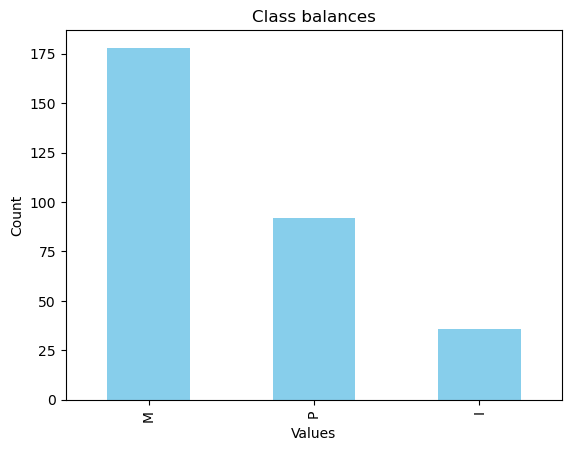

In [79]:
value_counts = tooth_labels['tooth_type'].value_counts()

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Class balances')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()

In [80]:
# each I to 6 images, each P to 2 images
def translation_augment(tooth_type, tx, ty):
    translated_images = []
    translation_matrix = np.array([[1.,0.,tx],[0.,1.,ty]])
    for i, row in tooth_labels[tooth_labels['tooth_type'] == tooth_type].iterrows():
        image = cv2.imread(row['image_path'])
        translated_images.append(translate(image, tx, ty))
    return translated_images

new_Ps = translation_augment('P', -2., 1.)
new_Is = []
translations = [(-7,1), (-4,1), (1, -4), (1, 4)]
for i in range(4): # translate each image 5 times to obtain enough incisors
    new = translation_augment('I', translations[i][0], translations[i][1])
    new_Is.extend(new)

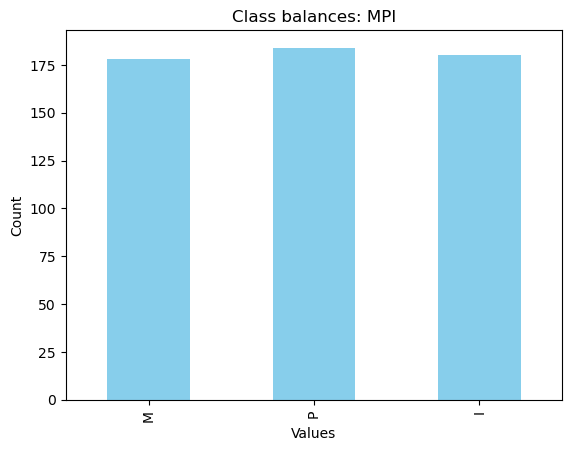

In [81]:
# re-plot histogram
# value_counts = tooth_labels['tooth_type'].value_counts()
value_counts['P'] += len(new_Ps)
value_counts['I'] += len(new_Is)

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Class balances: MPI')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()


In [83]:
# Save new images
for i, image in enumerate(new_Is):
    cv2.imwrite(f'{torch_imagefolder_path}_balanced/MPI/I/aug_{i}.png', image)

for i, image in enumerate(new_Ps):
    cv2.imwrite(f'{torch_imagefolder_path}_balanced/MPI/P/aug_{i}.png', image)
